In [5]:
# Load temperature data from a CSV file
temperature_data = np.loadtxt('temperature.csv', delimiter=',', skiprows=1)  # Skip header if present


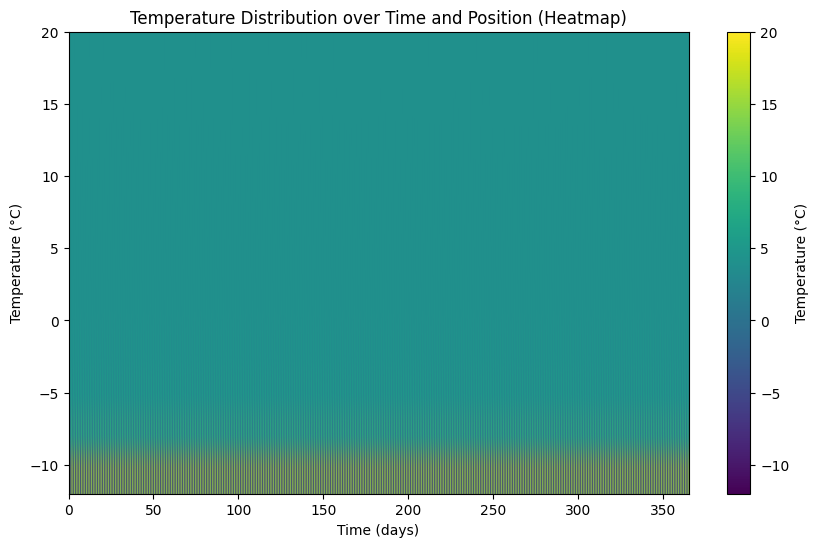

In [8]:
# Plot heatmap
plt.figure(figsize=(10, 6))
plt.imshow(Temperature.T, aspect='auto', extent=[0, 365, np.min(Temperature), np.max(Temperature)], origin='lower', cmap='viridis')
plt.colorbar(label="Temperature (°C)")
plt.xlabel("Time (days)")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Distribution over Time and Position (Heatmap)")
plt.show()
# Temperature: 0,5 m, spacing 0.5 m, 11 columns
# Time total time: 365 days, one record very 30 mins. Sampling period =30 mins

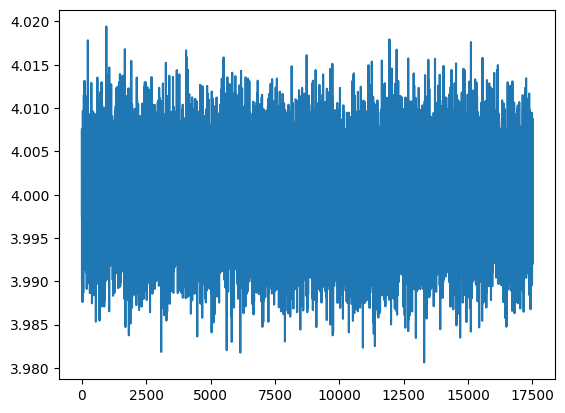

In [9]:
plt.plot(Temperature[:,10])

In [10]:
Temperature.shape

(17520, 11)

## For k and W estimation using 2-position data

In [11]:
# Function to fit sine wave model to temperature data
def fit_sine_wave(time, temperature, omega, T0):
    def T_model(t, A, phi):
        return T0 + A * np.sin(omega * t + phi)

    # Initial guess: Amplitude A = 1, phi = 0, T0 (average temperature)
    popt, _ = curve_fit(T_model, time, temperature, p0=[1, 0])
    return popt  # Return fitted parameters A, phi


# Function to calculate k and W
def estimate_k_W(A1, A2, Phi1, Phi2, z1, z2, omega):
    """
    Calculate the thermal conductivity k and frequency W.

    Parameters:
    A1, A2: Amplitude values at positions z1 and z2
    Phi1, Phi2: Phase angles at positions z1 and z2
    z1, z2: Spatial positions
    omega: Angular frequency

    Returns:
    k: Thermal conductivity
    W: Frequency
    """

    # Calculate thermal conductivity k
    k = (np.abs(z1 - z2)**2 * omega * np.log(A2 / A1)) / (
        (Phi2 - Phi1) * (np.abs(Phi2 - Phi1)**2 + np.log(A2 / A1)**2)
    )

    # Calculate frequency W
    W = (omega * np.abs(z2 - z1)) / np.abs(Phi2 - Phi1) * (
        (2 * np.log(A2 / A1)**2) / ((Phi2 - Phi1)**2 + np.log(A2 / A1)**2) - 1
    )

    return k, W

In [12]:
# Simulate temperature data for position z1 and z2 (e.g., z1 = 1m, z2 = 2m)
z1_index = 1  # Index for z1 = 1m
z2_index = 2  # Index for z2 = 2m
temperature_at_z1 = Temperature[:, z1_index]
temperature_at_z2 = Temperature[:, z2_index]
Temperature.shape

(17520, 11)

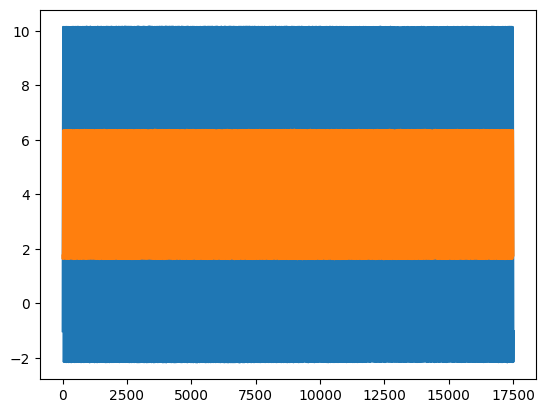

In [13]:
plt.plot(temperature_at_z1)
plt.plot(temperature_at_z2)

In [14]:
# Fit the sine model to the temperature data at z1 and z2
params_z1 = fit_sine_wave(time , temperature_at_z1,omega,T0=4)  # Time in days
params_z2 = fit_sine_wave(time , temperature_at_z2,omega,T0=4)  # Time in days

A1, phi1 = params_z1
A2, phi2 = params_z2

# Output the fitted parameters
print(f"Position z1 (1m): A1 = {A1}, phi1 = {phi1}")
print(f"Position z2 (2m): A2 = {A2}, phi2 = {phi2}")



# Estimate k and W using the fitted values
k_est, W_est = estimate_k_W(A1, A2, phi1, phi2, z1=9*0.5, z2=10*0.5, omega=omega)

# Output the estimated k and W
print(f"Estimated thermal conductivity k: {k_est}")
print(f"Estimated water flux W: {W_est}")


Position z1 (1m): A1 = 6.15131085421201, phi1 = -0.95343904319034
Position z2 (2m): A2 = 2.3648020938684255, phi2 = -1.9068740333516387
Estimated thermal conductivity k: 9.99982580338707e-06
Estimated water flux W: 1.0129884892052035e-07


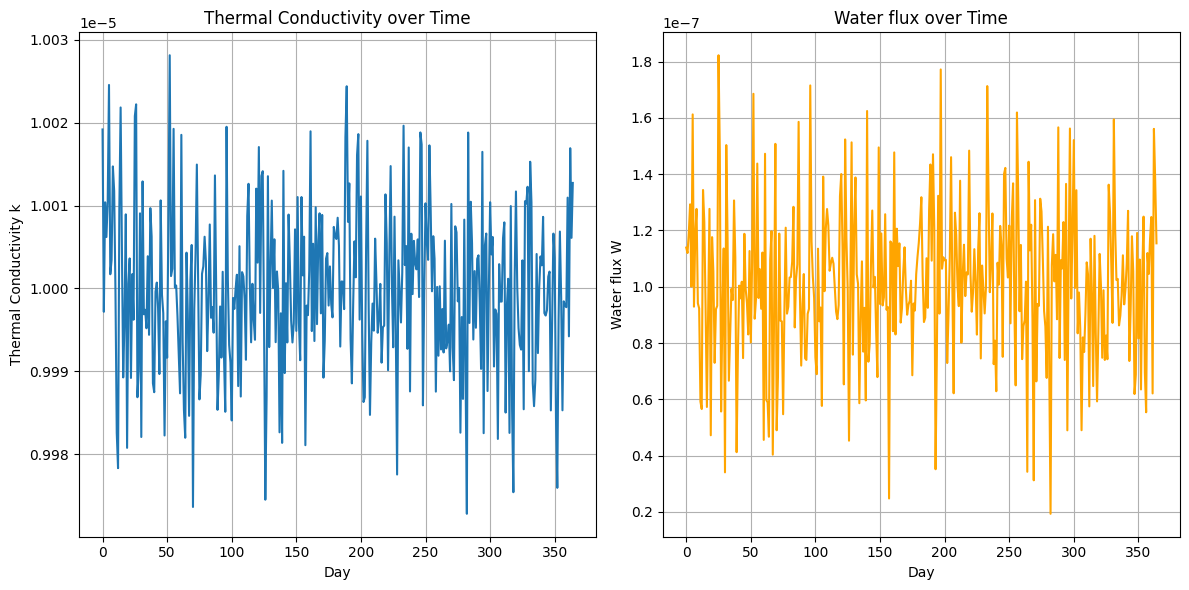

In [15]:
# Calculate k and W for each 24-hour period and store the results
num_days = 365
k_values = []  # List to store k values
W_values = []  # List to store W values
for day in range(num_days):
    # Extract data for the current 24-hour period (start and end indices)
    start_idx = day * 48  # 48 samples per day
    end_idx = (day + 1) * 48
    time_period = time[start_idx:end_idx] / 1  # Convert time to days
    temperature_at_z1 = Temperature[start_idx:end_idx, 1]  # Position z1 = 1*0.5m
    temperature_at_z2 = Temperature[start_idx:end_idx, 2]  # Position z2 = 2*0.5m

    # Fit the sine model to the data for z1 and z2
    params_z1 = fit_sine_wave(time_period, temperature_at_z1, omega, T0)
    params_z2 = fit_sine_wave(time_period, temperature_at_z2, omega, T0)

    A1, phi1 = params_z1
    A2, phi2 = params_z2

    # Estimate k and W using the fitted values
    k_est, W_est = estimate_k_W(A1, A2, phi1, phi2, z1=1*0.5, z2=2*0.5, omega=omega)

    # Store the estimated k and W for the current 24-hour period
    k_values.append(k_est)
    W_values.append(W_est)

# Plot the estimated k and W over time
plt.figure(figsize=(12, 6))

# Plot k values over time
plt.subplot(1, 2, 1)
plt.plot(range(num_days), k_values, label='Estimated k')
plt.xlabel('Day')
plt.ylabel('Thermal Conductivity k')
plt.title('Thermal Conductivity over Time')
plt.grid(True)

# Plot W values over time
plt.subplot(1, 2, 2)
plt.plot(range(num_days), W_values, label='Estimated W', color='orange')
plt.xlabel('Day')
plt.ylabel('Water flux W')
plt.title('Water flux over Time')
plt.grid(True)

plt.tight_layout()
plt.show()